In [1]:
from wavemix_lite import WaveMixLiteSemanticSegmentation

import torch
from torchvision import datasets, transforms

import random
import matplotlib.pyplot as plt
import numpy as np

from typing import Any, Tuple

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
from PIL import Image
from tqdm import tqdm

from utils import load_model, load_yaml

/home/seungwon/anaconda3/envs/cv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Set the configuration
config = load_yaml("/home/seungwon/Projects/deep-learning-projects/cv-03-wavemix-lite/config/cityscapes_config.yml")

# Training setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(config['data']['seed'])
if device == 'cuda':
  torch.cuda.manual_seed_all(config['data']['seed'])

# Set the transform
transform=A.Compose([A.Resize(1024, 2048),
                     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                     ToTensorV2()])

class dataset(datasets.Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']

void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [255, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']
class_map = dict(zip(valid_classes, range(len(valid_classes))))

n_classes=len(valid_classes)
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = 255
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

# Set the test data
val_data = dataset(config['data']['data_path'], split='val', mode='fine', target_type='semantic', transform=transform)
val_loader = torch.utils.data.DataLoader(val_data,
                                        batch_size=config['data']['batch_size'],
                                        shuffle=config['data']['shuffle'],
                                        num_workers=config['data']['num_workers'],
                                        drop_last=config['data']['drop_last']
                                        , pin_memory=True)

# Set the model
model = WaveMixLiteSemanticSegmentation(num_class=config['model']['num_class'],
                                       num_block=config['model']['num_block'],
                                       dim_channel=config['model']['dim_channel'],
                                       mul_factor=config['model']['mul_factor'],
                                       dropout=config['model']['dropout'],
                                       device=device).to(device)

model = load_model('/home/seungwon/Projects/deep-learning-projects/cv-03-wavemix-lite/models/cityscapes/2023.07.11.17.47.10/cityscapes_best.pt', model)
print(model, device)

Load the yaml file from /home/seungwon/Projects/deep-learning-projects/cv-03-wavemix-lite/config/cityscapes_config.yml
Loaded the model from /home/seungwon/Projects/deep-learning-projects/cv-03-wavemix-lite/models/cityscapes/2023.07.11.17.47.10/cityscapes_best.pt successfully
(WaveMixLiteSemanticSegmentation(
  (wavemixlite): WaveMixLite(
    (wavemixlite): ModuleList(
      (0): WaveMixLiteBlock(
        (conv_input): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
        (twod_dwt): twoDDWT()
        (fc): Sequential(
          (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): GELU(approximate=none)
          (2): Dropout(p=0.5, inplace=False)
          (3): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_trans): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): WaveMixLiteBlock(
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1500x300 with 0 Axes>

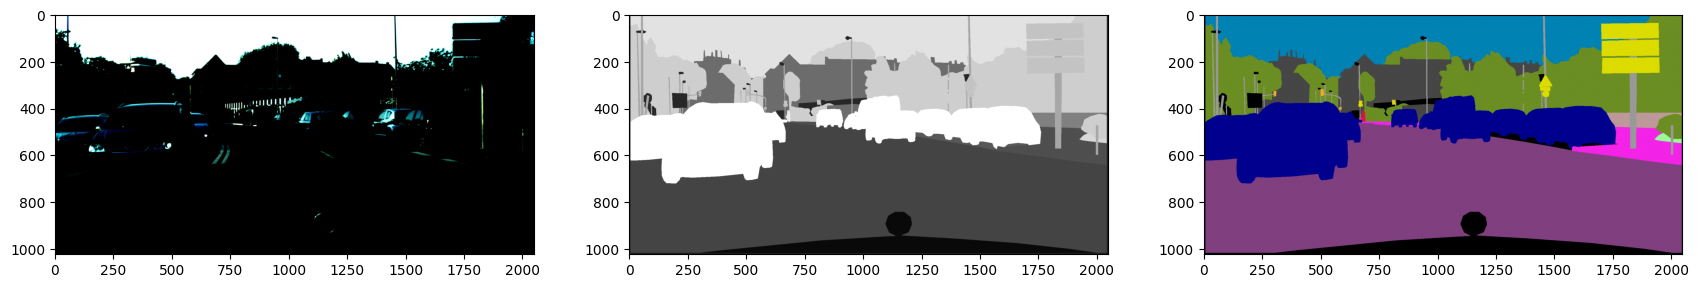

In [18]:
n_to_show = 1
np.random.seed(777)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

idx = random.randrange(0, len(val_data))

data = val_data[idx][0]
label = val_data[idx][1]

sem = encode_segmap(label.clone())
color_sem = decode_segmap(sem.clone())

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(21,8))
ax[0].imshow(data.permute(1, 2, 0))
ax[1].imshow(label, cmap='gray')
ax[2].imshow(color_sem)